## Dataset CIFAR10 + ResNet18

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1200

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

dataloaders = {
    'train': trainloader,
    'test': testloader,
}

dataset_sizes = {
    'train': len(trainset),
    'test': len(testset),
}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
dataset_sizes

{'test': 10000, 'train': 50000}

In [ ]:
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, width=64):
        super(ResNet, self).__init__()
        self.in_planes = width

        self.conv1 = nn.Conv2d(3, width, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width)
        self.layer1 = self._make_layer(block, width, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 2*width, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 4*width, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 8*width, num_blocks[3], stride=2)
        self.linear = nn.Linear(8*width*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=10, width=64):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, width=width)

In [ ]:
import tqdm.notebook as tq
from tqdm import tqdm


def train_model(model, criterion, optimizer, num_epochs=25):
    test_err_log = []
    for epoch in tq.tqdm(range(num_epochs)):
        for phase in ['train', 'test']:
            model.train(phase == 'train')

            running_corrects = 0

            if phase == 'train':
                for data in dataloaders[phase]:
                    inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
            else:
                with torch.no_grad():
                    for data in dataloaders[phase]:
                        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # statistics
                        running_corrects += torch.sum(preds == labels).type(torch.float)


            if phase == 'test':
                epoch_acc = running_corrects / dataset_sizes[phase]
                test_err_log.append(1 - epoch_acc)
    
    return model, test_err_log

## Сравнение процесса обучения моделей в зависимости от их ширины

In [ ]:
import torch.optim as optim


WIDTHS = [64, 12, 3]
WIDTH_NAMES = ['Large', 'Intermediate', 'Small']
NUM_EPOCHS = 200

test_logs = []

for width, name in zip(WIDTHS, WIDTH_NAMES):
    print('Processing {} model with {} width'.format(name, width))
    model = ResNet18(width=width).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model, test_acc_log = train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS)
    test_logs.append(test_acc_log)
    print()

Processing Large model with 64 width


  0%|          | 0/200 [00:00<?, ?it/s]


Processing Intermediate model with 12 width


  0%|          | 0/200 [00:00<?, ?it/s]


Processing Small model with 3 width


  0%|          | 0/200 [00:00<?, ?it/s]

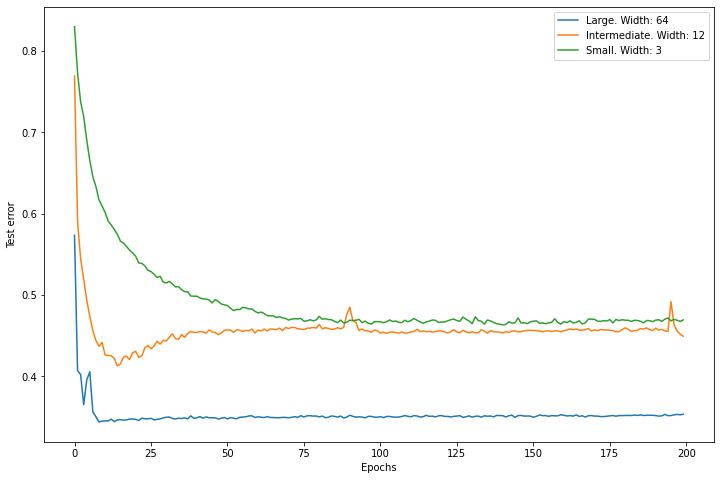

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for width, name, test_log in zip(WIDTHS, WIDTH_NAMES, test_logs):
    plt.plot(range(len(test_log)), test_log, label=name + '. Width: ' + str(width))
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Test error')
plt.show()

In [ ]:
import torch.optim as optim


WIDTHS = range(1, 26)
NUM_EPOCHS = 100

test_logs = []

for width in WIDTHS:
    print('Processing model with {} width'.format(width))
    model = ResNet18(width=width).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model, test_acc_log = train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS)
    test_logs.append(test_acc_log)
    print()

Processing model with 1 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 2 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 3 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 4 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 5 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 6 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 7 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 8 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 9 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 10 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 11 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 12 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 13 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 14 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 15 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 16 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 17 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 18 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 19 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 20 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 21 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 22 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 23 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 24 width


  0%|          | 0/100 [00:00<?, ?it/s]


Processing model with 25 width


  0%|          | 0/100 [00:00<?, ?it/s]

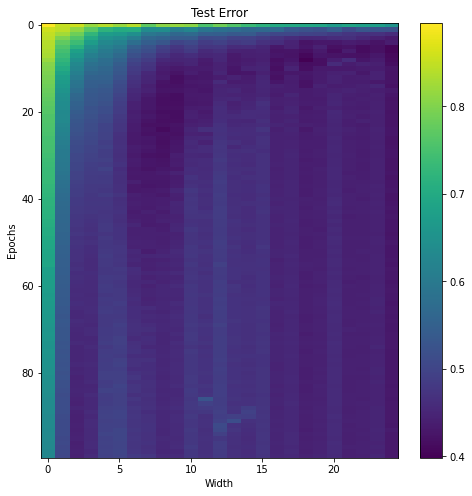

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# heatmap_data = []
# for log in test_logs:
#     heatmap_data.append([])
#     for v in log:
#         heatmap_data[-1] = np.append(heatmap_data[-1], v.cpu().item())
plt.figure(figsize=(8, 8))
plt.imshow(np.array(heatmap_data).T, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Test Error')
plt.xlabel('Width')
plt.ylabel('Epochs')
plt.show()

In [ ]:
import tqdm.notebook as tq
from tqdm import tqdm


def train_model(model, criterion, optimizer, train_samples, num_epochs=25):
    test_err_log = []
    for epoch in tq.tqdm(range(num_epochs)):
        for phase in ['train', 'test']:
            model.train(phase == 'train')

            running_corrects = 0

            if phase == 'train':
                for data in dataloaders[phase]:
                    inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
            else:
                with torch.no_grad():
                    for data in dataloaders[phase]:
                        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # statistics
                        running_corrects += torch.sum(preds == labels).type(torch.float)


            if phase == 'test':
                epoch_acc = running_corrects / dataset_sizes[phase]
                test_err_log.append(1 - epoch_acc)
    
    return model, test_err_log

## Сравнение процесса обучения в зависимости от количества данных

In [ ]:
import torch.optim as optim


DATA_SAMPLES = [50000, 25000, 12500]
NAMES = ['Large', 'Intermediate', 'Small']
NUM_EPOCHS = 1000
WIDTH = 16

test_logs = []

for train_samples, name in zip(DATA_SAMPLES, NAMES):
    transform = transforms.Compose([transforms.ToTensor()])

    batch_size = 1200

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainset_sampled = torch.utils.data.Subset(trainset, list(range(train_samples)))
    trainloader = torch.utils.data.DataLoader(trainset_sampled, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    dataloaders = {
        'train': trainloader,
        'test': testloader,
    }

    dataset_sizes = {
        'train': len(trainset_sampled),
        'test': len(testset),
    }

    classes = ('plane', 'car', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    print('Processing model with {} amount of data: {} samples'.format(name, dataset_sizes['train']))
    model = ResNet18(width=WIDTH).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model, test_acc_log = train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS)
    test_logs.append(test_acc_log)
    print()

Files already downloaded and verified
Files already downloaded and verified
Processing model with Large amount of data: 50000 samples


  0%|          | 0/1000 [00:00<?, ?it/s]


Files already downloaded and verified
Files already downloaded and verified
Processing model with Intermediate amount of data: 25000 samples


  0%|          | 0/1000 [00:00<?, ?it/s]


Files already downloaded and verified
Files already downloaded and verified
Processing model with Small amount of data: 12500 samples


  0%|          | 0/1000 [00:00<?, ?it/s]

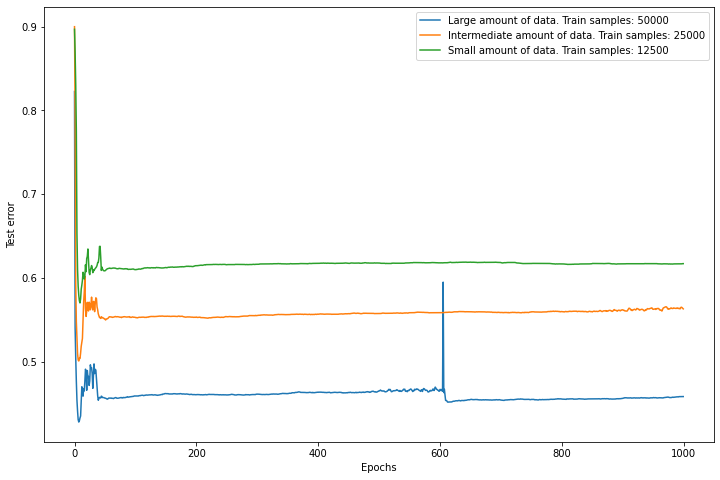

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for train_samples, name, test_log in zip(DATA_SAMPLES, NAMES, test_logs):
    plt.plot(range(len(test_log)), test_log, label=name + ' amount of data. Train samples: ' + str(train_samples))
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Test error')
plt.show()